In [13]:
from pytorch_flows import flows as fnn
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

device = torch.device('cuda:2')

modules = []
for _ in range(20):
    modules += [
        fnn.MADE(2, 64, 2, act='relu'),
        fnn.BatchNormFlow(2),
        fnn.Reverse(2)
    ]

In [14]:
model = fnn.FlowSequential(*modules)

for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)

In [15]:
sum(p.numel() for p in model.parameters()  if p.requires_grad)

/root/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


94880

In [16]:
model.to(device);

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/root/miniconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cond']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
from sklearn import datasets
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

trainable_parametrs = list(model.parameters()) # list of all trainable parameters in a flow
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4, weight_decay=1e-6) # choose an optimizer, use module torch.optim
losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)

B = 5000
for t in tqdm(range(50000)):
    cond = torch.randn(B, 2).to(device)
    noisy_circles = torch.tensor(datasets.make_circles(n_samples=B, factor=.5, noise=.05)[0], 
                                 dtype=torch.float32).to(device) + cond
    loss = -model.log_probs(noisy_circles, cond).mean()
        
    if loss != loss:
        continue
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    scheduler.step(loss)
    
    if t % 10 == 0:
        clear_output()
        print('iter %s:' % t, 'loss = %.3f' % loss, optimizer.param_groups[0]['lr'])
        plt.figure()
        plt.plot(losses)
        # plt.ylim(1.1, 3)
        plt.show()

iter 5410: loss = 1.503 1.220703125e-08


KeyboardInterrupt: 

In [ ]:
model.eval()

In [ ]:
samples = model.sample(num_samples=1000, cond_inputs=torch.tensor([0., 0.]).repeat(1000, 1).float().to(device))

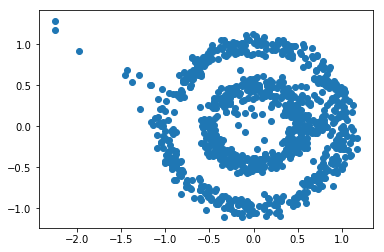

In [51]:
plt.scatter(*samples.cpu().detach().numpy().T)